In [1]:
import tensorflow as tf
import tensorflow_io as tfio

In [2]:
import os

PATH = 'C:\\Users\\CrankMuffler\\Documents\\GitHub\\RA2_alpine_lads'

os.chdir(PATH)

In [3]:
from utils.config import Config

test_config = Config('./utils/stadlerm_config.json')

In [4]:
import pandas as pd
import numpy as np

def get_dataframes(training_csv):
        info = pd.read_csv(training_csv)
        features = info.columns
        parts = ["LH","RH","LF","RF"]
        dataframes = {}
        for part in parts:
            dataframes[part] = info.loc[:,["Patient_ID"]+[s for s in features if part in s]].copy()
            dataframes[part]["total_fig_score"] = dataframes[part].loc[:,[s for s in features if part in s]].sum(axis=1)
            dataframes[part]["Patient_ID"] = dataframes[part]["Patient_ID"].astype(str) + f"-{part}"
        # use left as reference
        # flip the Rights
        dataframes["RH"].columns = dataframes["LH"].columns 
        dataframes["RF"].columns = dataframes["LF"].columns 
        data_hands = pd.concat((dataframes["RH"],dataframes["LH"]))
        data_feet = pd.concat((dataframes["RF"],dataframes["LF"]))
        return data_hands,data_feet

training_csv_file = os.path.join(test_config.train_location, "training.csv")

data_hands, data_feet = get_dataframes(training_csv_file)

In [5]:
from dataset.image_loading import load_and_orient_image


AUTOTUNE = tf.data.experimental.AUTOTUNE

def init_dataset(config, df_data, flip_str):
    def do_thing(file):
        path = config.train_location+"/"+file+".jpg"
        
        img = load_and_orient_image(path)
        
        print(img)
        
        return img
    
    def load_images(file, y):
        img = tf.py_function(do_thing, [file], tf.uint8)
        
        print(img.shape)
        
        img = tf.image.convert_image_dtype(img, dtype = tf.float32)
        img = tf.convert_to_tensor(img)
        
        print(img)
        
        return img, y

    dataset = tf.data.Dataset.from_tensor_slices((df_data["Patient_ID"].values, df_data.loc[:, df_data.columns != 'Patient_ID'].values))
    dataset = dataset.map(load_images, num_parallel_calls=AUTOTUNE)
    
    return dataset

hands_dataset = init_dataset(test_config, data_hands, "RF")

<unknown>
<unknown>


In [6]:
import dataset.augments as aug
import numpy as np

augments = [aug.random_rotation]

def resize_img(img,y):
    # function that just resizes the image
    img = tf.image.resize(img, [256, 256])
    
    return img, y

def _randomly_augment_dataset(dataset):
    for aug in augments:
        dataset = _apply_random_augment(dataset, aug)

    # After augmentations, scale values back to lie between 0 & 1
    dataset = dataset.map(_clip_image, num_parallel_calls=AUTOTUNE)

    return dataset

def _place_holder(img, y):
    return img, y

def _clip_image(img, y):
    return tf.clip_by_value(img, 0, 1), y

def _apply_random_augment(dataset, aug, cutoff = 0.75):
    # Randomly apply each augmentation 1 - cutoff% of the time
    if(tf.random.uniform([], minval = 0, maxval = 1) > cutoff):
        return dataset.map(aug, num_parallel_calls=AUTOTUNE)
    else:
        return dataset

In [7]:
hands_dataset = hands_dataset.shuffle(buffer_size=200)

# hands_dataset = _randomly_augment_dataset(hands_dataset)

hands_dataset = hands_dataset.map(resize_img, num_parallel_calls=AUTOTUNE)

Tensor("args_0:0", dtype=float32)


ValueError: in converted code:

    <ipython-input-6-507a96439877>:11 resize_img  *
        img = tf.image.resize(img, [256, 256])
    C:\Users\CrankMuffler\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\image_ops_impl.py:1357 resize_images_v2
        skip_resize_if_same=False)
    C:\Users\CrankMuffler\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\image_ops_impl.py:1072 _resize_images_common
        raise ValueError('\'images\' contains no shape.')

    ValueError: 'images' contains no shape.


In [9]:
import matplotlib.pyplot as plt

hands_dataset = hands_dataset.shuffle(buffer_size=200)

for image, label in hands_dataset.take(10):
    print(label)
    
    plt.figure()
    plt.imshow(image[:, :, 0], cmap="gray")
    plt.show()

UnknownError: AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'read'
Traceback (most recent call last):

  File "C:\Users\CrankMuffler\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\Image.py", line 2813, in open
    fp.seek(0)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'seek'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "C:\Users\CrankMuffler\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\script_ops.py", line 234, in __call__
    return func(device, token, args)

  File "C:\Users\CrankMuffler\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\script_ops.py", line 123, in __call__
    ret = self._func(*args)

  File "<ipython-input-6-ab758951526d>", line 10, in do_thing
    img = load_and_orient_image(path)

  File "C:\Users\CrankMuffler\Documents\GitHub\RA2_alpine_lads\dataset\image_loading.py", line 8, in load_and_orient_image
    img = PIL.Image.open(file)

  File "C:\Users\CrankMuffler\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\Image.py", line 2815, in open
    fp = io.BytesIO(fp.read())

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'read'


	 [[{{node EagerPyFunc}}]]

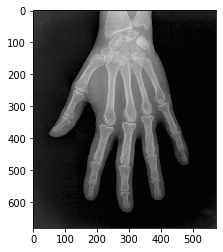

In [10]:
file = "UAB372-LH"

path = test_config.train_location+"/"+file+".jpg"
img = tf.io.read_file(path)
img = tf.image.decode_jpeg(img, channels=1)
#img = tf.image.convert_image_dtype(img, tf.float32)

plt.figure()
plt.imshow(np.repeat(np.array(img),3,axis=2),cmap="Greys")
plt.show()

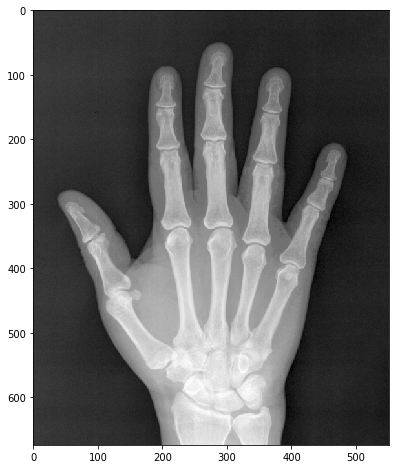

In [13]:
from dataset.image_loading import load_and_orient_image

file = 'UAB374-RH'

img = load_and_orient_image(test_config.train_location+"/"+file+".jpg", False)

plt.figure(figsize= (8, 8))
plt.imshow(img, cmap="gray")
plt.show()

In [12]:
def load_images(file,y):
    img = load_image_file(file)
    
    img = np.array(img)
    
    
    # path = self.config.train_location+"/"+file+".jpg"
    # img = tf.io.read_file(path)
    #img = tf.keras.preprocessing.image.img_to_array(img[:, :, 0:3], dtype = np.string_)
    
    # img = np.array(img)
    
    # img = img[:, :, 0:3]
    
    # img = tf.convert_to_tensor(img)
    # img = tf.image.decode_jpeg(img)
    # img = tf.image.convert_image_dtype(img, dtype = tf.float32)
        
    return img, y

file = "UAB013-RH"

img, y = load_images(test_config.train_location+"/"+file+".jpg", 0)

NameError: name 'load_image_file' is not defined

INFO - Applied random_rotation: tf.Tensor(-4.4036293, shape=(), dtype=float32)


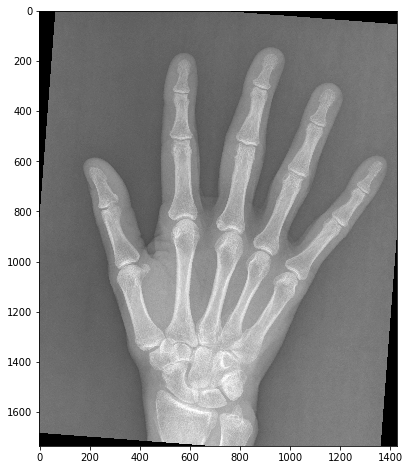

In [92]:
plt.figure(figsize= (8, 8))
plt.imshow(aug.random_rotation(img, 0)[0], cmap="gray")
plt.show()

INFO - Applied random_rotation: tf.Tensor(8.029135, shape=(), dtype=float32)


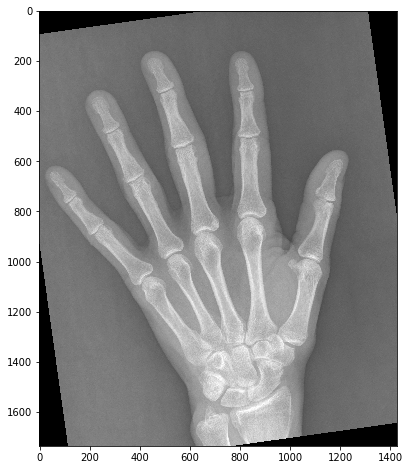

In [68]:
changed_image = aug.random_rotation(tf.image.convert_image_dtype(img, dtype = tf.float32), 0)[0]

plt.figure(figsize= (8, 8))
plt.imshow(changed_image,cmap="gray")
plt.show()

In [88]:
filenames = os.listdir(test_config.train_location)

is_rgb = np.array([])

for idx, filename in enumerate(filenames):
    if filename.endswith(".jpg"):
        img = load_image_file(test_config.train_location+"/"+filename, 0)
        
        if(img.mode != 'RGB'):
            is_rgb = np.append(is_rgb, filename)
            

In [95]:
print(is_rgb.size)
print(is_rgb)

151
['UAB055-RH.jpg' 'UAB057-RH.jpg' 'UAB070-LH.jpg' 'UAB070-RH.jpg'
 'UAB104-LH.jpg' 'UAB104-RF.jpg' 'UAB104-RH.jpg' 'UAB125-RH.jpg'
 'UAB140-RH.jpg' 'UAB142-RH.jpg' 'UAB223-LH.jpg' 'UAB223-RH.jpg'
 'UAB225-RH.jpg' 'UAB228-LH.jpg' 'UAB228-RH.jpg' 'UAB231-LH.jpg'
 'UAB231-RH.jpg' 'UAB232-LH.jpg' 'UAB236-LH.jpg' 'UAB236-RH.jpg'
 'UAB243-LH.jpg' 'UAB244-LH.jpg' 'UAB244-RH.jpg' 'UAB246-LH.jpg'
 'UAB246-RH.jpg' 'UAB251-LH.jpg' 'UAB251-RH.jpg' 'UAB252-LH.jpg'
 'UAB252-RH.jpg' 'UAB267-LH.jpg' 'UAB267-RH.jpg' 'UAB270-LH.jpg'
 'UAB271-RH.jpg' 'UAB277-LH.jpg' 'UAB277-RH.jpg' 'UAB278-LH.jpg'
 'UAB280-LH.jpg' 'UAB280-RH.jpg' 'UAB286-RH.jpg' 'UAB288-LH.jpg'
 'UAB301-RH.jpg' 'UAB302-RH.jpg' 'UAB307-LH.jpg' 'UAB307-RH.jpg'
 'UAB310-LH.jpg' 'UAB317-LH.jpg' 'UAB318-RH.jpg' 'UAB319-LH.jpg'
 'UAB319-RH.jpg' 'UAB323-RH.jpg' 'UAB326-LH.jpg' 'UAB326-RH.jpg'
 'UAB329-LH.jpg' 'UAB329-RH.jpg' 'UAB331-LH.jpg' 'UAB331-RH.jpg'
 'UAB333-LH.jpg' 'UAB333-RH.jpg' 'UAB334-LH.jpg' 'UAB334-RH.jpg'
 'UAB335-LH.jpg' 'UAB